## Quick Start

To get started with *pymgrid*, first [clone or install](../../html/getting_started.html) the package.

This notebook shows how to define a simple microgrid, create actions to control it, and read the results. Microgrids can be defined by either defining a set of modules and then passing them to the ``Microgrid`` constructor or by a YAML config file. We detail the first case here.

In [836]:
import numpy as np
import pandas as pd

np.random.seed(0)

from pymgrid import Microgrid
from pymgrid.modules import (
    BatteryModule,
    LoadModule,
    RenewableModule,
    GridModule)

### Defining a Microgrid

We can then define some components of our microgrid. We will define two batteries, one with a capacity of 100 kWh and another with a slower charging rate and lower efficiency but a capacity of 1000 kWh.

In [839]:
small_battery = BatteryModule(min_capacity=10,
                              max_capacity=100,
                              max_charge=50,
                              max_discharge=50,
                              battery_cost_cycle=3.0,
                              efficiency=0.9,
                              init_soc=0.2)

large_battery = BatteryModule(min_capacity=10,
                              max_capacity=1000,
                              max_charge=10,
                              max_discharge=10,
                              battery_cost_cycle=5.0,
                              efficiency=0.7,
                              init_soc=0.2)

We will also define a load and photovoltaic (pv) module -- the latter representing, say, a solar farm -- with some random data. We will define 90 days worth of data, in hourly increments.

In [841]:
load_ts = 100+100*np.random.rand(24*90) # random load data in the range [100, 200].
pv_ts = 200*np.random.rand(24*90) # random pv data in the range [0, 200].

load = LoadModule(time_series=load_ts)

pv = RenewableModule(time_series=pv_ts)

Finally, we define an external electrical grid to fill any energy gaps. 

The grid time series must contain three or four columns. The first three denote import price, export price, and carbon dioxide production per kWh. If a fourth column exists, it denotes the grid status (as a bool); if it does not, the grid is assumed to always be up and running.

In [843]:
grid_ts = [0.2, 0.1, 0.5] * np.ones((24*90, 3))

grid = GridModule(max_import=100,
                  max_export=100,
                  time_series=grid_ts)

We can then pass these to the ``Microgrid`` constructor to define a microgrid. Here, we give our renewable module the name "pv".

In [845]:
modules = [
    small_battery, 
    large_battery,
    ('pv', pv),
    load,
    grid]

microgrid = Microgrid(modules, add_unbalanced_module=True, loss_load_cost=10.0, overgeneration_cost=2.0)

Printing the microgrid will tell us the modules contained in that microgrid. By default a ``balancing`` module is added to keep track of any unmet demand or excess production. This can be disabled by passing ``unbalanced_energy_module=False``, but is not recommended.

In [847]:
print(microgrid)

Microgrid([load x 1, pv x 1, balancing x 1, battery x 2, grid x 1])


We can then access the modules in the microgrid by name or by key:

In [849]:
print(microgrid.modules.pv)

[RenewableModule(time_series=<class 'numpy.ndarray'>, raise_errors=False, forecaster=NoForecaster, forecast_horizon=0, forecaster_increase_uncertainty=False, provided_energy_name=renewable_used)]


In [850]:
print(microgrid.modules.grid is microgrid.modules['grid'])

True


### Controlling a microgrid

You must pass an action for each ``controllable`` module to control the microgrid. The fixed modules are stored in the attribute ``microgrid.controllable``:

In [852]:
microgrid.controllable

{
  "battery": "[BatteryModule(min_capacity=10, max_capacity=100, max_charge=50, max_discharge=50, efficiency=0.9, battery_cost_cycle=3.0, battery_transition_model=None, init_charge=None, init_soc=0.2, raise_errors=False), BatteryModule(min_capacity=10, max_capacity=1000, max_charge=10, max_discharge=10, efficiency=0.7, battery_cost_cycle=5.0, battery_transition_model=None, init_charge=None, init_soc=0.2, raise_errors=False)]",
  "grid": "[GridModule(max_import=100, max_export=100)]"
}

As we can see, our "load", "battery", and "grid" modules are fixed.

We can also view what modules we need to pass an action for by getting an empty action from the microgrid. Here, all ``None`` values must be replaced to pass this action as a control.

In [854]:
print(microgrid.get_empty_action())

{'battery': [None, None], 'grid': [None]}


We can then simply define a control for these modules. Before doing so, we will reset our microgrid and then check its current state.

In [856]:
microgrid.reset()
microgrid.state_series.to_frame()

0
load    0 load_current         -171.518937
pv      0 renewable_current     145.789539
battery 0 soc                     0.200000
          current_charge         20.000000
        1 soc                     0.200000
          current_charge        200.000000
grid    0 import_price_current    0.200000
          export_price_current    0.100000
          co2_per_kwh_current     0.500000
          grid_status_current     1.000000

We will attempt to meet our load demand of 169.646919 by using our available renewable and then discharging our batteries:

In [858]:
load = -1.0 * microgrid.modules.load.item().current_load
pv = microgrid.modules.pv.item().current_renewable

In [859]:
net_load = load + pv # negative if load demand exceeds pv

if net_load > 0:
    net_load = 0.0

For our batteries, we will attempt to generate the lower of the excess load and the maximum production.

In [861]:
battery_0_discharge = min(-1*net_load, microgrid.modules.battery[0].max_production)
net_load += battery_0_discharge

battery_1_discharge = min(-1*net_load, microgrid.modules.battery[1].max_production)
net_load += battery_1_discharge

Finally, we will let our grid clean up the rest -- or as must as it can.

In [863]:
grid_import = min(-1*net_load, microgrid.modules.grid.item().max_production)

Putting this together, we have our control. 

**Note that positive values denote energy moving into the microgrid and negative values denote energy leaving the microgrid.**

In [865]:
control = {"battery" : [battery_0_discharge, battery_1_discharge],
           "grid": [grid_import]}

control

{'battery': [9.0, 7.0], 'grid': [9.729397408557361]}

We can then run the microgrid with this control. Since this control is not normalized, we pass ``normalized=False``.

In [867]:
obs, reward, done, info = microgrid.run(control, normalized=False)

### Analyzing Results

After passing a control to the microgrid, we can view the results by viewing the microgrid's -- or any of the modules -- logs. 

The microgrid's log has one row for each action taken. There are values for both the actions -- e.g. the amount of load met -- as well as the state: for example, the current load. 

**Note that the state values are the values of the state from *before* the action was taken.**

The columns are a ``pd.MultiIndex``, with three levels: module names, module name enumeration (e.g. which number of each module name we are in) and property.

For example, since there is one ``load``, all of its log entries will be available under the key ``('load', 0)``. Since there are two batteries, there will be both ``(battery, 0)`` and ``(battery, 1)``.

We can see that we met all of our load:

In [870]:
microgrid.log.loc[:, pd.IndexSlice['load', 0, :]]

module_name     load                         
module_number      0                         
field         reward    load_met load_current
0                0.0  171.518937  -171.518937

And consumed all available pv, even though we did not define a control for it:

In [872]:
microgrid.log.loc[:, pd.IndexSlice['pv', 0, :]]

module_name       pv                                             
module_number      0                                             
field         reward curtailment renewable_used renewable_current
0                0.0         0.0     145.789539        145.789539

Since we have two batteries, we will have log entries for each of them:

In [874]:
microgrid.log.loc[:5, 'load']

module_number      0                         
field         reward    load_met load_current
0                0.0  171.518937  -171.518937

In [875]:
microgrid.log.loc[:5, 'balancing']

module_number      0                         
field         reward loss_load overgeneration
0               -0.0       0.0            0.0

In [876]:
microgrid.log.loc[:5, 'pv']

module_number      0                                             
field         reward curtailment renewable_used renewable_current
0                0.0         0.0     145.789539        145.789539

In [877]:
microgrid.log.loc[:5, 'battery']

module_number      0                                                     \
field         reward discharge_amount charge_amount  soc current_charge   
0              -30.0              9.0           0.0  0.2           20.0   

module_number      1                                                     
field         reward discharge_amount charge_amount  soc current_charge  
0              -50.0              7.0           0.0  0.2          200.0

In [878]:
microgrid.log.loc[:5, 'grid']

module_number         0                                         \
field            reward co2_production grid_import grid_export   
0             -1.945879       4.864699    9.729397         0.0   

module_number                                                                \
field         import_price_current export_price_current co2_per_kwh_current   
0                              0.2                  0.1                 0.5   

module_number                      
field         grid_status_current  
0                             1.0

### Plotting Results

We can also utilize pandas plotting functionality to view results. To illustrate this, we will run the microgrid for an additional ten steps with randomly sampled actions.

In [880]:
actions = []
for _ in range(20):
    action = microgrid.sample_action(strict_bound=True)
    actions.append(action)
    obs, reward, done, info = microgrid.run(action)
pd.DataFrame.from_dict(actions)

,battery,grid
0,"[0.3013260863841051, 0.08167126508348677]",[0.44685965922843884]
1,"[0.24319981204283506, 0.7905333354077368]",[0.38144561378471853]
2,"[0.9131639247894314, 0.18953043009076098]",[0.93054657416206]
3,"[0.3831267743223594, 0.12024160222586466]",[0.5021501704999409]
4,"[0.2097668723310583, 0.7490364969626329]",[0.6513094388112957]
5,"[0.23636935198722914, 0.41754621986829077]",[0.8871362031077711]
6,"[0.7047259192925475, 0.7436305616542056]",[0.11338257123155238]
7,"[0.9086278372105359, 0.5024317633850213]",[0.9475721682300842]
8,"[0.4342775455590132, 0.7692256838949744]",[0.9721138959242149]
9,"[0.6593122834443693, 0.577273336360849]",[0.3667081396093276]


In [881]:
df = microgrid.get_log()

In [882]:
df.columns

MultiIndex([(     'load', 0,                               'reward'),
            (     'load', 0,                             'load_met'),
            (     'load', 0,                         'load_current'),
            (       'pv', 0,                               'reward'),
            (       'pv', 0,                          'curtailment'),
            (       'pv', 0,                       'renewable_used'),
            (       'pv', 0,                    'renewable_current'),
            ('balancing', 0,                               'reward'),
            ('balancing', 0,                            'loss_load'),
            ('balancing', 0,                       'overgeneration'),
            (  'battery', 0,                               'reward'),
            (  'battery', 0,                     'discharge_amount'),
            (  'battery', 0,                        'charge_amount'),
            (  'battery', 0,                                  'soc'),
            (  'batt

In [883]:
# Filtra columnas cuyo tercer nivel sea 'reward'
reward_columns = [col for col in df.columns if col[2] == 'reward']

# Selecciona esas columnas del DataFrame
df_rewards = df[reward_columns]
df_rewards

module_name     load     pv    balancing     battery                  grid  \
module_number      0      0            0           0          1          0   
field         reward reward       reward      reward     reward     reward   
0                0.0    0.0    -0.000000  -30.000000 -50.000000  -1.945879   
1                0.0    0.0  -948.680379  -68.189968 -43.915491   1.062807   
2                0.0    0.0  -489.511120  -83.971251 -18.152517   2.371088   
3                0.0    0.0    -0.000000 -120.893834 -35.879983 -17.221863   
4                0.0    0.0  -243.287212  -45.981081 -41.042001  -0.086007   
5                0.0    0.0  -633.722721  -93.048294 -11.843304  -6.052378   
6                0.0    0.0  -646.806290  -85.825721 -18.892807 -15.485448   
7                0.0    0.0  -715.850416  -51.028503 -11.021381   7.732349   
8                0.0    0.0    -0.000000 -119.373405 -12.568834 -17.902887   
9                0.0    0.0  -784.550197  -32.093646 -14.912885 -18.884556   
10               0.0    0.0  -623.665548  -35.806525  -6.993136   2.665837   
11               0.0    0.0 -1603.324179 -140.796456 -17.775345   1.750391   
12               0.0    0.0    -0.000000 -113.149799 -35.900673  -9.705794   
13               0.0    0.0 -1184.357846 -141.029057 -32.722892  -6.717704   
14               0.0    0.0  -431.527762  -49.593213 -30.219675   6.311979   
15               0.0    0.0    -0.000000  -52.596014 -19.437219  -9.720916   
16               0.0    0.0  -672.932414 -120.666258 -27.973960  -5.996014   
17               0.0    0.0   -19.187662  -77.063252 -46.815945  -4.617307   
18               0.0    0.0  -585.365394  -64.543772 -48.977410   0.554400   
19               0.0    0.0  -400.535540  -80.208594  -3.201360  -1.059855   
20               0.0    0.0  -755.789319  -62.495360 -40.403063 -15.217095   

module_name        balance  
module_number            0  
field               reward  
0               -81.945879  
1             -1059.723031  
2              -589.263800  
3              -173.995680  
4              -330.396300  
5              -744.666697  
6              -767.010266  
7              -770.167952  
8              -149.845125  
9              -850.441284  
10             -663.799372  
11            -1760.145588  
12             -158.756267  
13            -1364.827498  
14             -505.028670  
15              -81.754148  
16             -827.568646  
17             -147.684165  
18             -698.332175  
19             -485.005349  
20             -873.904837

In [884]:
df['pv']

module_number      0                                             
field         reward curtailment renewable_used renewable_current
0                0.0    0.000000     145.789539        145.789539
1                0.0    0.000000     113.839194        113.839194
2                0.0    0.000000     157.807195        157.807195
3                0.0  135.799877      30.239439        166.039316
4                0.0    0.000000     168.586972        168.586972
5                0.0    0.000000      82.928830         82.928830
6                0.0    0.000000      84.254679         84.254679
7                0.0    0.000000     185.253176        185.253176
8                0.0  115.743927      16.608792        132.352719
9                0.0    0.000000      16.093437         16.093437
10               0.0    0.000000     108.437391        108.437391
11               0.0    0.000000      71.201452         71.201452
12               0.0   77.143909     120.343089        197.486998
13               0.0    0.000000       2.731081          2.731081
14               0.0    0.000000     122.436175        122.436175
15               0.0  101.532671      43.191948        144.724619
16               0.0    0.000000      57.781354         57.781354
17               0.0    0.000000     194.728304        194.728304
18               0.0    0.000000     171.907325        171.907325
19               0.0    0.000000     183.130568        183.130568
20               0.0    0.000000       3.846412          3.846412

In [885]:
df['balancing'][0]['loss_load'][:5]

0     0.000000
1    94.868038
2    48.951112
3     0.000000
4    24.328721
Name: loss_load, dtype: float64

In [886]:
df

module_name     load                              pv              \
module_number      0                               0               
field         reward    load_met load_current reward curtailment   
0                0.0  171.518937  -171.518937    0.0    0.000000   
1                0.0  160.276338  -160.276338    0.0    0.000000   
2                0.0  154.488318  -154.488318    0.0    0.000000   
3                0.0  142.365480  -142.365480    0.0  135.799877   
4                0.0  164.589411  -164.589411    0.0    0.000000   
5                0.0  143.758721  -143.758721    0.0    0.000000   
6                0.0  189.177300  -189.177300    0.0    0.000000   
7                0.0  196.366276  -196.366276    0.0    0.000000   
8                0.0  138.344152  -138.344152    0.0  115.743927   
9                0.0  179.172504  -179.172504    0.0    0.000000   
10               0.0  152.889492  -152.889492    0.0    0.000000   
11               0.0  156.804456  -156.804456    0.0    0.000000   
12               0.0  192.559664  -192.559664    0.0   77.143909   
13               0.0  107.103606  -107.103606    0.0    0.000000   
14               0.0  108.712930  -108.712930    0.0    0.000000   
15               0.0  102.021840  -102.021840    0.0  101.532671   
16               0.0  183.261985  -183.261985    0.0    0.000000   
17               0.0  177.815675  -177.815675    0.0    0.000000   
18               0.0  187.001215  -187.001215    0.0    0.000000   
19               0.0  197.861834  -197.861834    0.0    0.000000   
20               0.0  179.915856  -179.915856    0.0    0.000000   

module_name                                       balancing              \
module_number                                             0               
field         renewable_used renewable_current       reward   loss_load   
0                 145.789539        145.789539    -0.000000    0.000000   
1                 113.839194        113.839194  -948.680379   94.868038   
2                 157.807195        157.807195  -489.511120   48.951112   
3                  30.239439        166.039316    -0.000000    0.000000   
4                 168.586972        168.586972  -243.287212   24.328721   
5                  82.928830         82.928830  -633.722721   63.372272   
6                  84.254679         84.254679  -646.806290   64.680629   
7                 185.253176        185.253176  -715.850416   71.585042   
8                  16.608792        132.352719    -0.000000    0.000000   
9                  16.093437         16.093437  -784.550197   78.455020   
10                108.437391        108.437391  -623.665548   62.366555   
11                 71.201452         71.201452 -1603.324179  160.332418   
12                120.343089        197.486998    -0.000000    0.000000   
13                  2.731081          2.731081 -1184.357846  118.435785   
14                122.436175        122.436175  -431.527762   43.152776   
15                 43.191948        144.724619    -0.000000    0.000000   
16                 57.781354         57.781354  -672.932414   67.293241   
17                194.728304        194.728304   -19.187662    1.918766   
18                171.907325        171.907325  -585.365394   58.536539   
19                183.130568        183.130568  -400.535540   40.053554   
20                  3.846412          3.846412  -755.789319   75.578932   

module_name                   ...                 grid                      \
module_number                 ...                    0                       
field         overgeneration  ... export_price_current co2_per_kwh_current   
0                        0.0  ...                  0.1                 0.5   
1                        0.0  ...                  0.1                 0.5   
2                        0.0  ...                  0.1                 0.5   
3                        0.0  ...                  0.1                 0.5   
4                   

Here we will plot the load met, pv consumed and loss load:

<Axes: >

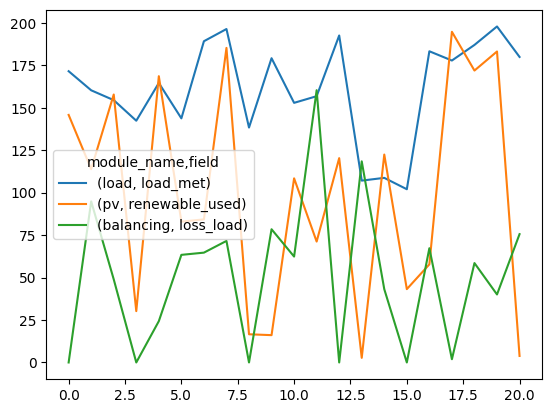

In [888]:
microgrid.log[[('load', 0, 'load_met'), 
               ('pv', 0, 'renewable_used'),
               ('balancing', 0, 'loss_load')]].droplevel(axis=1, level=1).plot()

In [889]:
microgrid.modules.balancing[0].loss_load_cost

10.0

In [890]:
microgrid.modules.balancing[0].overgeneration_cost

2.0

In [891]:
info

{'load': [('absorbed_energy', 179.91585642167234)],
 'battery': [('provided_energy', 18.74860807268317),
  ('provided_energy', 5.656428866415121)],
 'grid': [('provided_energy', 76.08547574323833),
  ('co2_production', 38.04273787161917)],
 'pv': [('provided_energy', 3.846411870309696), ('curtailment', 0.0)],
 'balancing': [('provided_energy', 75.57893186902602)]}

In [892]:
reward

-873.9048374127217